In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import TargetEncoder

# import xgboost as xgb
import lightgbm as lgb

from optuna.integration import LightGBMPruningCallback #XGBoostPruningCallback, CatBoostPruningCallback
import optuna

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_str = "lgb_"
study_name = 'minus_bin_'

# feature_list = ['weight_capacity_te', 'brand', 'material', 'size', 'compartments', 'style', 'color', 'laptop_compartment', 'is_waterproof']
TE_features = [
    'weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color',
    'laptop_compartment', 'is_waterproof', 'size', 'material', 'style'
]
TE_new_cols = [col + "_te" for col in TE_features]
features = TE_features + TE_new_cols
features = [col for col in TE_features if col not in ['laptop_compartment', 'is_waterproof']]


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=40)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    # train_fold["weight_capacity_te"] = te.fit_transform(train_fold[["weight_capacity"]], train_fold[target])
    # val_fold["weight_capacity_te"] = te.transform(val_fold[["weight_capacity"]])
    train_fold[TE_new_cols] = (
        te.fit_transform(train_fold[TE_features], train_fold[target])
    )
    val_fold[TE_new_cols] = (
        te.transform(val_fold[TE_features])
    )
    data_splits.append((train_fold, val_fold))

In [ ]:
%%time

from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        'random_state': 42,
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 5, 1000), # the {n}th accuracy on the validation set does not improve, stop training
        'verbose': -1,  # -1: Fatal, 0: Warning, 1: Info, 2: Debug
        'objective': 'regression',
        'metric': 'rmse',
        'force_row_wise': True,

        # default = 10.0,  used for the categorical features
        'cat_l2':  trial.suggest_float('cat_l2', 0.01, 100),

        # if set to true, when evaluating node splits LightGBM will check only one randomly-chosen threshold for each feature
        'extra_trees': trial.suggest_categorical("extra_trees", [True, False]),

        # subset of features on each iteration (tree) to select
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # colsample_bytree is ignored when feature_fraction is set
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 0.35),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),

        # max number of bins that feature values will be bucketed in
        'max_bin': trial.suggest_int('max_bin', 2, 10000),

        # <= 0 means no limit. Used to deal with over-fitting when data is small. Tree still grows leaf-wise. 
        'max_depth': trial.suggest_int('max_depth', -1, 1000),  

        # Very important to prevent over-fitting. Setting it to hundreds or thousands is enough for a large dataset.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'min_split_gain': 0.5,
        
        'n_estimators': trial.suggest_int('n_estimators', 100, 15000),

        # main parameter to control the complexity of the tree model. Should be smaller than 2^max_depth
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),

        # subsample is ignored when bagging_fraction is set
        # 'subsample': trial.suggest_float('subsample', 0.2, 0.25),
        
    }

    rmse_list = []
    for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

        train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
        valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
      
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            valid_names=['train_0', 'valid_0'],
            callbacks=[
                # LightGBMPruningCallback(trial, "l1", valid_name="valid_0"),
                LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
                lgb.log_evaluation(-1)                   # Suppress training logs
            ]
        )
        y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
        rmse = root_mean_squared_error(valid_fold[target], y_pred)
        # rmse = mean_absolute_error(valid_fold[target], y_pred)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=model_str + study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=5000)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["metric"] = "rmse"
best_params["force_row_wise"] = True

[I 2025-02-17 08:01:14,012] A new study created in RDB with name: lgb_all_2025-02-17_08-01
[I 2025-02-17 08:04:31,482] Trial 0 finished with value: 38.656171960708285 and parameters: {'early_stopping_rounds': 6, 'bagging_fraction': 0.7086379192345196, 'bagging_freq': 2, 'cat_l2': 7.322559175738244, 'extra_trees': False, 'feature_fraction': 0.6145315997690319, 'learning_rate': 0.052857635707669326, 'max_bin': 7193, 'max_depth': 894, 'min_samples_leaf': 5, 'n_estimators': 5947, 'num_leaves': 179, 'lambda_l1': 0.0009638303983113146, 'lambda_l2': 0.0004778199253943356}. Best is trial 0 with value: 38.656171960708285.
[I 2025-02-17 08:40:37,807] Trial 1 finished with value: 38.657407848652454 and parameters: {'early_stopping_rounds': 206, 'bagging_fraction': 0.8187847815324745, 'bagging_freq': 1, 'cat_l2': 14.156269184317159, 'extra_trees': True, 'feature_fraction': 0.979333246482582, 'learning_rate': 0.012857706605457786, 'max_bin': 6278, 'max_depth': 248, 'min_samples_leaf': 15, 'n_estima


Number of finished trials: 5000
Best trial: 44
Best value (RMSE): 38.65543923885193
Best hyperparameters: {'early_stopping_rounds': 390, 'bagging_fraction': 0.9954892076290114, 'bagging_freq': 3, 'cat_l2': 19.943225836972967, 'extra_trees': False, 'feature_fraction': 0.9583014726425529, 'learning_rate': 0.21124741547142464, 'max_bin': 7566, 'max_depth': 648, 'min_samples_leaf': 14, 'n_estimators': 1570, 'num_leaves': 68, 'lambda_l1': 7.772617123196223e-06, 'lambda_l2': 0.0006810978623249646}
CPU times: user 1d 11h 24min 23s, sys: 4h 5s, total: 1d 15h 24min 29s
Wall time: 11h 20min


In [ ]:
Best value (RMSE): 38.65543923885193
Best hyperparameters: {'early_stopping_rounds': 390, 'bagging_fraction': 0.9954892076290114, 'bagging_freq': 3, 'cat_l2': 19.943225836972967, 'extra_trees': False, 'feature_fraction': 0.9583014726425529, 'learning_rate': 0.21124741547142464, 'max_bin': 7566, 'max_depth': 648, 'min_samples_leaf': 14, 'n_estimators': 1570, 'num_leaves': 68, 'lambda_l1': 7.772617123196223e-06, 'lambda_l2': 0.0006810978623249646}
CPU times: user 1d 11h 24min 23s, sys: 4h 5s, total: 1d 15h 24min 29s
Wall time: 11h 20min

In [7]:
best_params

{'early_stopping_rounds': 390,
 'bagging_fraction': 0.9954892076290114,
 'bagging_freq': 3,
 'cat_l2': 19.943225836972967,
 'extra_trees': False,
 'feature_fraction': 0.9583014726425529,
 'learning_rate': 0.21124741547142464,
 'max_bin': 7566,
 'max_depth': 648,
 'min_samples_leaf': 14,
 'n_estimators': 1570,
 'num_leaves': 68,
 'lambda_l1': 7.772617123196223e-06,
 'lambda_l2': 0.0006810978623249646,
 'random_state': 42,
 'verbose': 0,
 'metric': 'rmse',
 'force_row_wise': True}

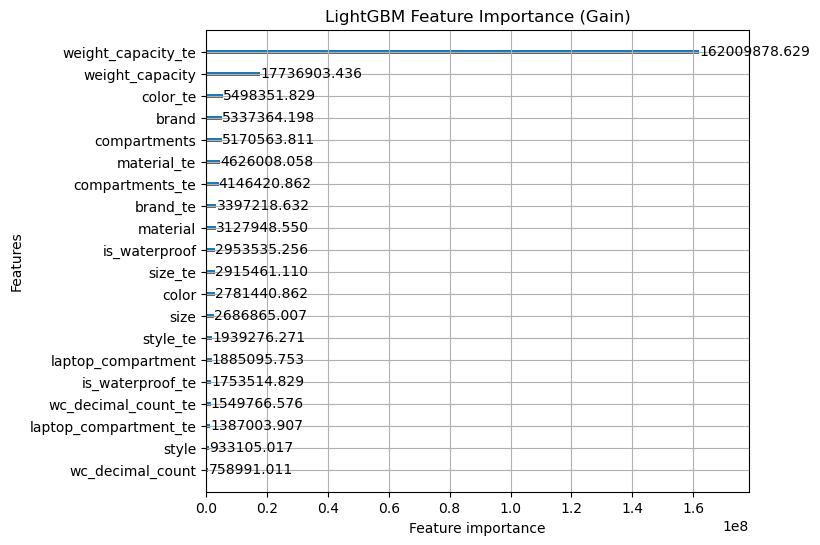

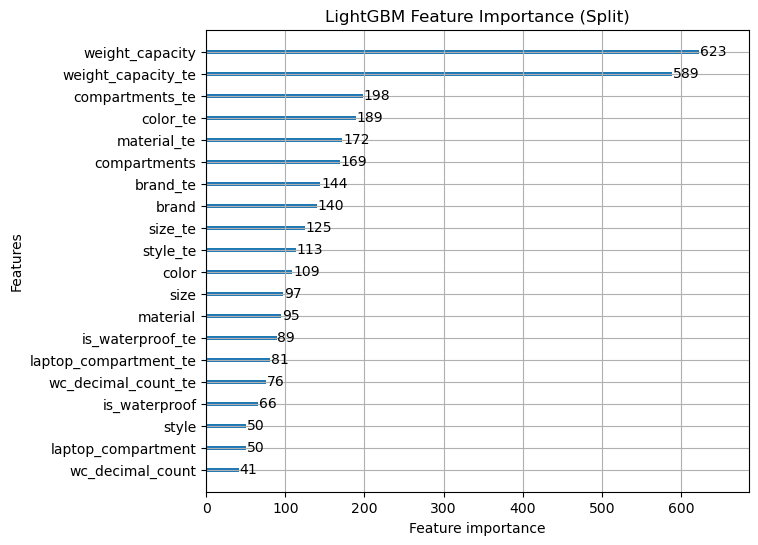

In [8]:
for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    break

model = lgb.train(params=best_params, train_set=train_data, valid_sets=[train_data, valid_data],
)

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [35]:
quantiles = [0.1, 0.9]  # Lower and upper bounds
quantile_models = {}

for q in quantiles:
    quantile_params = best_params.copy()
    quantile_params.update({
        "objective": "quantile",
        "alpha": q
    })

    train_data = lgb.Dataset(train_df_encoded[feature_list], label=train_df_encoded[target]) 
    quantile_models[q] = lgb.train(params=quantile_params, train_set=train_data)

In [40]:
X_test = test_df_encoded[feature_list]

y_pred = model.predict(X_test)
y_lower = quantile_models[0.1].predict(X_test)
y_upper = quantile_models[0.9].predict(X_test)

# Print sample output
for i in range(5):
    print(f"Pred: {y_pred[i]:.2f}, Lower: {y_lower[i]:.2f}, Upper: {y_upper[i]:.2f}")

Pred: 81.86, Lower: 28.83, Upper: 134.78
Pred: 82.75, Lower: 29.19, Upper: 135.18
Pred: 82.41, Lower: 27.90, Upper: 136.48
Pred: 80.79, Lower: 29.13, Upper: 134.30
Pred: 78.58, Lower: 25.82, Upper: 133.87


In [47]:
quantile_width = y_upper - y_lower

results_df = pd.DataFrame({
    "y_pred": y_pred,
    "y_lower": y_lower,
    "y_upper": y_upper,
    "midpoint": (y_upper + y_lower) / 2,
    "quantile_width": quantile_width
})

results_df.sort_values(by="quantile_width", ascending=True)

,y_pred,y_lower,y_upper,midpoint,quantile_width
164459,40.794629,20.188331,96.596631,58.392481,76.408300
127511,45.020558,20.432004,97.763583,59.097794,77.331578
187325,40.921457,20.848764,103.836507,62.342635,82.987744
167616,40.962314,21.078594,106.160919,63.619756,85.082325
106540,52.789885,20.620531,105.713287,63.166909,85.092755
...,...,...,...,...,...
121583,91.360337,17.698150,142.676008,80.187079,124.977859
36044,113.610736,21.983540,147.442600,84.713070,125.459060
44639,86.131928,17.879055,143.760218,80.819636,125.881162
17915,105.529693,21.843741,148.751697,85.297719,126.907957


<Axes: xlabel='y_lower', ylabel='Count'>

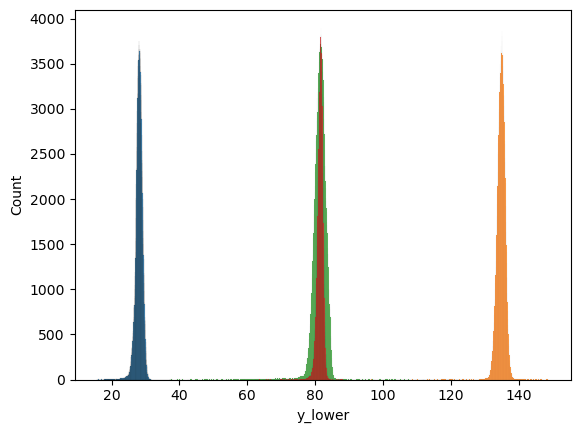

In [51]:
sns.histplot(results_df.y_lower)
sns.histplot(results_df.y_upper)
sns.histplot(results_df.y_pred, label='y_pred')
sns.histplot(results_df.midpoint, label='midpoint')

In [54]:
results_df.y_pred.mean(), results_df.y_pred.std()

(81.3754467345461, 2.1841610293828015)

In [56]:
results_df.midpoint.mean(), results_df.midpoint.std()

(81.48431038633113, 0.9113560742149481)

In [62]:
submit_path = f'..//submissions//' + model_str + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
print("Saving to:", submit_path)
# y_pred.to_csv("submission.csv", index=False)

submit_df = test_df[['id']].copy()
submit_df['Price'] = results_df.midpoint
# submit_df['Price'] = np.mean(predictions, axis=0) # Average the predictions
submit_df.to_csv(submit_path, index=False)
# print(f"Submission file saved as submission.csv\n")
submit_df.head(5)

Saving to: ..//submissions//lgb_2025-02-10_19-59.csv


,id,Price
0,300000,81.805773
1,300001,82.185220
2,300002,82.193602
3,300003,81.716690
4,300004,79.843914


In [57]:
# Define a weight based on quantile width (higher width → more weight on upper)
weight = np.clip(quantile_width / quantile_width.max(), 0, 1)

# Adjust prediction using a blend of y_pred and y_upper
results_df["adjusted_pred"] = (1 - weight) * y_pred + weight * y_upper

In [59]:
weight

array([0.82942038, 0.82979378, 0.85001023, ..., 0.84304221, 0.8390487 ,
       0.82126352])

In [58]:
results_df

,y_pred,y_lower,y_upper,midpoint,quantile_width,adjusted_pred
0,81.855731,28.832035,134.779511,81.805773,105.947476,125.751793
1,82.752197,29.187633,135.182807,82.185220,105.995174,126.258791
2,82.413418,27.904823,136.482380,82.193602,108.577557,128.372589
3,80.793437,29.129325,134.304056,81.716690,105.174730,124.852521
4,78.579239,25.821316,133.866512,79.843914,108.045196,125.343569
...,...,...,...,...,...,...
199995,79.979490,28.106667,133.651492,80.879079,105.544825,124.326957
199996,78.953991,26.177099,134.103670,80.140385,107.926571,125.550723
199997,82.737569,28.362203,136.049688,82.205946,107.687485,127.681936
199998,81.791271,28.526647,135.704015,82.115331,107.177367,127.026689


In [19]:
results_df[results_df.y_pred != results_df.y_upper]

,y_pred,y_lower,y_upper,quantile_width


In [ ]:
# for i, (train_fold, valid_fold) in enumerate(data_splits, 1):

#     train_data = lgb.Dataset(train_fold[feature_list], label=train_fold[target])
#     valid_data = lgb.Dataset(valid_fold[feature_list], label=valid_fold[target], reference=train_data)
    
#     model = lgb.train(
#         params=best_params,
#         train_set=train_data,
#         valid_sets=[train_data, valid_data],
#         valid_names=['train_0', 'valid_0'],
#         callbacks=[
#             LightGBMPruningCallback(trial, "rmse", valid_name="valid_0"),
#             lgb.log_evaluation(-1)                   # Suppress training logs
#         ]
#     )
#     y_pred = model.predict(valid_fold[feature_list], num_iteration=model.best_iteration)
#     rmse = root_mean_squared_error(valid_fold[target], y_pred)
#     rmse_list.append(rmse)

# return np.mean(rmse_list)